<a href="https://colab.research.google.com/github/gilan6/MS-CDI/blob/main/MS_CDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard libraries
import numpy as np
import pprint

# Third-party libraries
import colorcet as cc
import matplotlib.pyplot as plt
# import scienceplots

# Local modules
from MS_CDI_IO import (
    load_inputs,
    load_outputs,
    save_inputs,
    save_outputs,
)

from produce_om import load_masks, load_objects
from MS_CDI_funcs import many_objects, power_spectrum, init_rec, create_measurements, mpie_multiplexed_cdi
from Param import Param, ScenarioParam, MaskParam, ObjParam, AlgParam
from plots import plot_rec_lines, phase_plot
from utils import gpu2cpu, cpu2gpu

# Set the style for plots (uses scienceplots, comment out for default matplotlib layout)
# plt.style.use(("science", "no-latex"))


## Run a single reconstruction with specified inputs

In [2]:
# Prepare inputs to run the reconstruction algorithm
p = Param(alg=AlgParam(iter_num=300), scenario=ScenarioParam(obj_num=1))  # Defaults are defined in Param.py. Recommended that you look inside.
frames = np.random.permutation(200)  # The 1st two indexes are used for a single object.
masks, rec_supp = load_masks(p)  # Replace with whatever modulators you like. rec_supp is the spatial support.
rec0 = init_rec(p)[0]  # Initiated externally for consistency. The function which does the reconstruction will initiate internally if not given as a parameter
obj = load_objects(frames[:2], p)[0]  # Replace with whatever object you would like to reconstruct
_, meas, beam_block = create_measurements(obj, masks, p)  # Calculate the multiplexed diffraction pattern. Also gives the beam-block mask if used.
pprint.pp(p)

Param(scenario=ScenarioParam(mask_num=2,
                             camera_n=512,
                             snr=30.0,
                             bit_depth=16,
                             block_width=0,
                             obj_num=1),
      mask=MaskParam(camera_n=512,
                     mask_type='binary',
                     filter_shape='circ',
                     filter_outer_limit=102.4,
                     filter_inner_limit=51.2,
                     supp_shape='square',
                     supp_size=178,
                     supp_out_shape='square',
                     supp_out_size=256),
      obj=ObjParam(camera_n=512,
                   filter_shape='square',
                   filter_outer_limit=409.6,
                   supp_shape='square',
                   supp_size=230),
      io=IOParam(save_data_to_file=False,
                 load_from_file=False,
                 save_data_path='Results/MsCDI_K_2.pkl',
                 save_temp_path='Results

In [8]:
rec, meas_errs, rec_errs = mpie_multiplexed_cdi(meas, obj, rec_supp, masks, beam_block, rec0, p)
print(10*np.log10(rec_errs.min()))

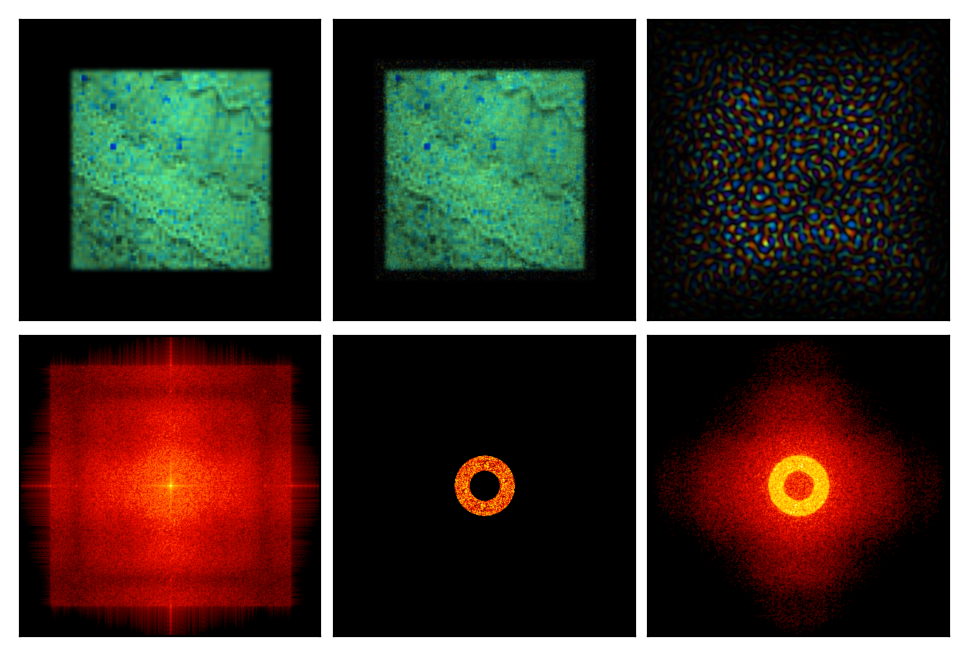

In [10]:
# Show results (Similar to Fig. 2 from the paper)
start_plt_ind = (p.scenario.camera_n - p.mask.supp_out_size) // 2 - 40
slicer = slice(start_plt_ind, -start_plt_ind, 1)
minds = (slicer, slicer, 0)
oinds = (slicer, slicer)

fig1, axs1 = plt.subplots(2, 3, figsize=(6, 4), dpi=200)

axs1[0, 0].imshow(phase_plot(obj[oinds]))
axs1[0, 1].imshow(phase_plot(rec[oinds]))
axs1[0, 2].imshow(phase_plot(masks[minds]))
axs1[1, 0].imshow(np.log10(abs(np.fft.fftshift(np.fft.fft2(gpu2cpu(obj)))) + 1e-8), cmap=cc.cm.fire, vmin=1)
axs1[1, 1].imshow(np.log10(abs(np.fft.fftshift(np.fft.fft2(gpu2cpu(masks[..., 0])))) + 1e-8), cmap=cc.cm.fire, vmin=1)
axs1[1, 2].imshow(np.log10(abs(np.fft.fftshift(gpu2cpu(power_spectrum(cpu2gpu(obj), masks, 2)[0])))), cmap=cc.cm.fire, vmin=4,)

fig1.subplots_adjust(wspace=0.04, hspace=0.05)

for ax in axs1.flatten():
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


## Reproduce the numerical results from the paper


In [20]:

# Load inputs
p_high_snr, frames, masks, rec0 = load_inputs('./Results/high_snr_in.h5')
# p_1m_high_snr = load_inputs('./Results/high_snr_1m_in.h5')[0]
# p_low_snr  = load_inputs('./Results/low_snr_in.h5')[0]
# p_low_snr_sep, _, separated_masks, _  = load_inputs('./Results/low_snr_sep_in.h5')


pprint.pp(p_high_snr)

Param(scenario=ScenarioParam(mask_num=2,
                             camera_n=512,
                             snr=30.0,
                             bit_depth=16,
                             block_width=0,
                             obj_num=100),
      mask=MaskParam(camera_n=512,
                     mask_type='binary',
                     filter_shape='circ',
                     filter_outer_limit=102.4,
                     filter_inner_limit=51.2,
                     supp_shape='square',
                     supp_size=178,
                     supp_out_shape='square',
                     supp_out_size=256),
      obj=ObjParam(camera_n=512,
                   filter_shape='square',
                   filter_outer_limit=409.6,
                   supp_shape='square',
                   supp_size=230),
      io=IOParam(save_data_to_file=False,
                 load_from_file=False,
                 save_data_path='Results/MsCDI_K_2.pkl',
                 save_temp_path='Resul

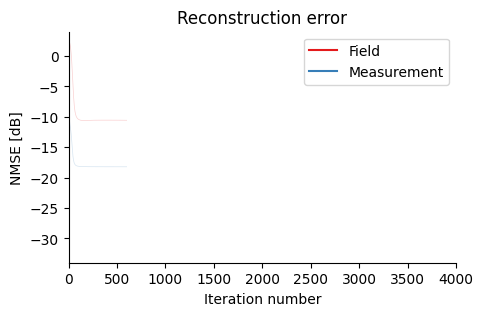

100% (1 of 1) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11


In [21]:
# p = p_high_snr

# To recreate just Fig. 2 uncomment the next line with high_snr_in.h5 as the inputs and run the following block.
p = Param(scenario=ScenarioParam(obj_num=1, bit_depth=12, snr=15.0))

objs, recs, meas_errs, rec_errs, _ = many_objects(p, frames, masks, rec0)

save_outputs(meas_errs, rec_errs, file_path='./Results/new_results.h5')
# To save space do not save all of the objects and reconstructions. You can if you like by uncommenting the next line
# save_outputs(meas_errs, rec_errs, objs, recs, file_path='./Results/new_results.h5')

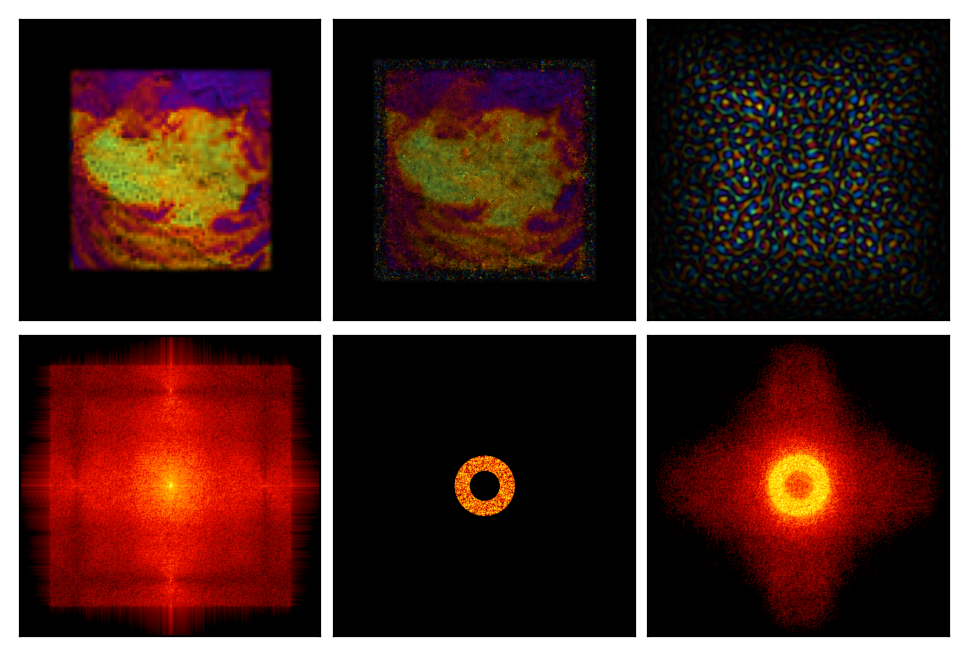

In [22]:
start_plt_ind = (p.scenario.camera_n - p.mask.supp_out_size) // 2 - 40
slicer = slice(start_plt_ind, -start_plt_ind, 1)
minds = (slicer, slicer, 0)
oinds = (0, slicer, slicer)

fig1, axs1 = plt.subplots(2, 3, figsize=(6, 4), dpi=200)

axs1[0, 0].imshow(phase_plot(objs[oinds]))
axs1[0, 1].imshow(phase_plot(recs[oinds]))
axs1[0, 2].imshow(phase_plot(masks[minds]))
axs1[1, 0].imshow(np.log10(abs(np.fft.fftshift(np.fft.fft2(gpu2cpu(objs[0])))) + 1e-8), cmap=cc.cm.fire, vmin=1 )
axs1[1, 1].imshow(np.log10(abs(np.fft.fftshift(np.fft.fft2(gpu2cpu(masks[..., 0])))) + 1e-8), cmap=cc.cm.fire, vmin=1)
axs1[1, 2].imshow(np.log10(abs(np.fft.fftshift(gpu2cpu(power_spectrum(cpu2gpu(objs[0]), masks, 2)[0])))), cmap=cc.cm.fire, vmin=4)
fig1.subplots_adjust(wspace=0.04, hspace=0.05)

for ax in axs1.flatten():
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


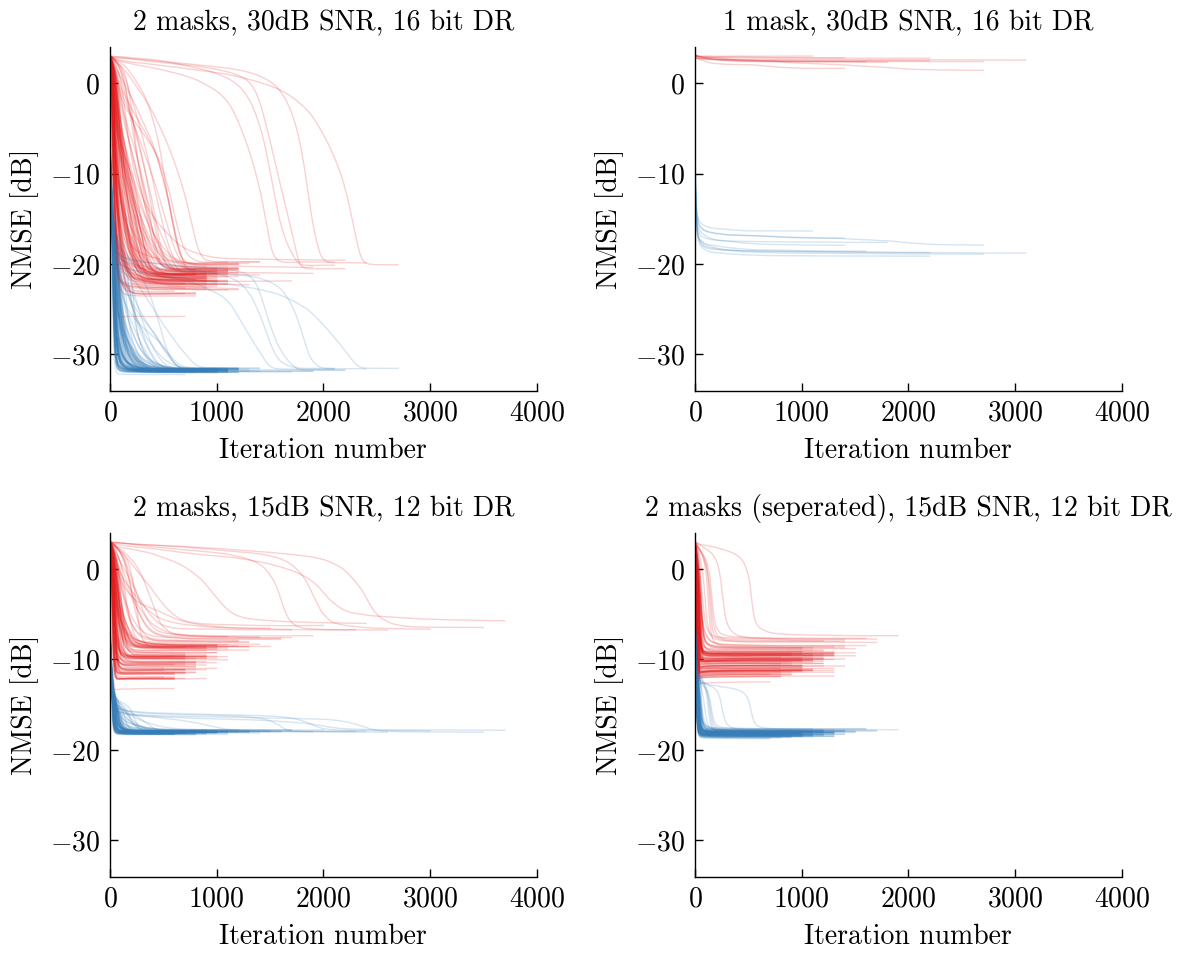

In [ ]:
# Load results externally

results_high_snr = load_outputs('./Results/high_snr_out.h5')
results_low_snr = load_outputs('./Results/low_snr_out.h5')
results_low_snr_sep = load_outputs('./Results/low_snr_sep_out.h5')
results_1m = load_outputs('./Results/high_snr_1m_out.h5')

titles = [
    "2 masks, 30dB SNR, 16 bit DR",
    "1 mask, 30dB SNR, 16 bit DR",
    "2 masks, 15dB SNR, 12 bit DR",
    "2 masks (seperated), 15dB SNR, 12 bit DR",
]
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=200)
for title, ax, res in zip(titles, axes.flatten(), [results_high_snr, results_1m, results_low_snr, results_low_snr_sep]):
    plot_rec_lines(res[1], res[0], ax=ax)
    ax.get_legend().remove()
    ax.set_title(title, fontsize=10)


fig.tight_layout()
# plt.savefig('../Diffraction-Imaging/Results/images/all_rec_lines.svg')